In [1]:
from sklearn.manifold import TSNE
import torch
import models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from utils import StratifiedBatchSampler
import pandas as pd
import numpy as np

In [2]:
vanilla_checkpoint = torch.load('resnet32-d509ac18.th')
moe_checkpoint = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Moe1_resnet32_5vK6SrW58X/ckpt.best.pth.tar')
nomoe_checkpoint = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Nomoe_resnet32_pOcgjojCCE/ckpt.pth.tar')
lorot_checkpoint = torch.load('/media/aristo/Data A/documents/kuliah/Project/CAM/checkpoint/cifar-CAM_Lorot_resnet32_nJmodpRnq5/ckpt.pth.tar')


In [3]:
vanilla_model = models.resnet32()
vanilla_model.load_state_dict(vanilla_checkpoint['state_dict'])
vanilla_model.eval()
vanilla_model.linear = torch.nn.Identity()

In [4]:
moe_model = models.Moe1()
moe_model.load_state_dict(moe_checkpoint['state_dict'])
moe_model.eval()
moe_model.classifier = torch.nn.Identity()

In [5]:
nomoe_model = models.Nomoe()
nomoe_model.load_state_dict(nomoe_checkpoint['state_dict'])
nomoe_model.eval()
nomoe_model.classifier = torch.nn.Identity()

In [6]:
lorot_model = models.Lorot()
lorot_model.load_state_dict(lorot_checkpoint['state_dict'])
lorot_model.eval()
lorot_model.classifier = torch.nn.Identity()

In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean,
                          std=std)
])

In [8]:
cifar_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)

In [9]:
batch_sampler = StratifiedBatchSampler(torch.tensor(cifar_dataset.targets), 100, True)

In [10]:
loader = DataLoader(cifar_dataset, batch_sampler=batch_sampler)

In [11]:
embeddings = torch.zeros(0,64)

In [12]:
labels = np.zeros((0),dtype=int)

In [13]:
batchlen = 25

In [14]:
seed = torch.seed()
for index, (img, label) in enumerate(loader):
    out = vanilla_model(img)
    embeddings = torch.cat((embeddings, out.detach()),dim=0)
    labels = np.concatenate((labels, label.numpy()),axis=0)
    if index >= batchlen:
        break
del vanilla_model
del vanilla_checkpoint

In [15]:
embeddings = embeddings.numpy()

In [16]:
embeddings.shape

(2600, 64)

In [17]:
perplexity = 50

In [18]:
tsne = TSNE(2,perplexity=perplexity, verbose=True)

In [19]:
tsne_proj = tsne.fit_transform(embeddings)


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2600 samples in 0.001s...
[t-SNE] Computed neighbors for 2600 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2600
[t-SNE] Computed conditional probabilities for sample 2000 / 2600
[t-SNE] Computed conditional probabilities for sample 2600 / 2600
[t-SNE] Mean sigma: 1.514018
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.541801
[t-SNE] KL divergence after 1000 iterations: 1.040116


In [20]:
df = pd.DataFrame(tsne_proj, columns=['x_vanilla', 'y_vanilla'])
df['label'] = pd.Categorical(labels)

In [21]:
torch.manual_seed(seed)
embeddings = torch.zeros(0,64)
labels = np.zeros((0),dtype=int)
for index, (img, label) in enumerate(loader):
    out = lorot_model(img)
    embeddings = torch.cat((embeddings, out.detach()),dim=0)
    labels = np.concatenate((labels, label.numpy()),axis=0)
    if index >= batchlen:
        break
del lorot_model
del lorot_checkpoint

In [22]:
tsne = TSNE(2,perplexity=perplexity,verbose=True)
tsne_proj = tsne.fit_transform(embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2600 samples in 0.002s...
[t-SNE] Computed neighbors for 2600 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2600
[t-SNE] Computed conditional probabilities for sample 2000 / 2600
[t-SNE] Computed conditional probabilities for sample 2600 / 2600
[t-SNE] Mean sigma: 1.436189
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.125771
[t-SNE] KL divergence after 1000 iterations: 1.060170


In [23]:
df.insert(0,'y_lorot', tsne_proj.T[1])
df.insert(0,'x_lorot', tsne_proj.T[0])

In [24]:
torch.manual_seed(seed)
embeddings = torch.zeros(0,64)
labels = np.zeros((0),dtype=int)
for index, (img, label) in enumerate(loader):
    out = nomoe_model(img)
    embeddings = torch.cat((embeddings, out.detach()),dim=0)
    labels = np.concatenate((labels, label.numpy()),axis=0)
    if index >= batchlen:
        break
del nomoe_model
del nomoe_checkpoint

In [25]:
tsne = TSNE(2,perplexity=perplexity,verbose=True)
tsne_proj = tsne.fit_transform(embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2600 samples in 0.001s...
[t-SNE] Computed neighbors for 2600 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2600
[t-SNE] Computed conditional probabilities for sample 2000 / 2600
[t-SNE] Computed conditional probabilities for sample 2600 / 2600
[t-SNE] Mean sigma: 1.423715
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.671341
[t-SNE] KL divergence after 1000 iterations: 1.066382


In [26]:
df.insert(0,'y_nomoe', tsne_proj.T[1])
df.insert(0,'x_nomoe', tsne_proj.T[0])

In [27]:
torch.manual_seed(seed)
embeddings = torch.zeros(0,64)
labels = np.zeros((0),dtype=int)
for index, (img, label) in enumerate(loader):
    out = moe_model(img)
    embeddings = torch.cat((embeddings, out.detach()),dim=0)
    labels = np.concatenate((labels, label.numpy()),axis=0)
    if index >= batchlen:
        break
del moe_model
del moe_checkpoint

In [28]:
tsne = TSNE(2,perplexity=perplexity,verbose=True)
tsne_proj = tsne.fit_transform(embeddings)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2600 samples in 0.001s...
[t-SNE] Computed neighbors for 2600 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2600
[t-SNE] Computed conditional probabilities for sample 2000 / 2600
[t-SNE] Computed conditional probabilities for sample 2600 / 2600
[t-SNE] Mean sigma: 1.484465
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.676121
[t-SNE] KL divergence after 1000 iterations: 1.055375


In [29]:
df.insert(0,'y_moe', tsne_proj.T[1])
df.insert(0,'x_moe', tsne_proj.T[0])

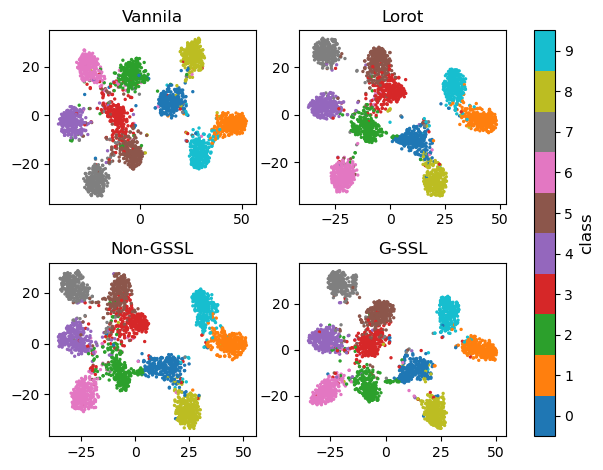

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0,0].scatter(x=df['x_vanilla'], y=df['y_vanilla'], c=df['label'], cmap='tab10', s=2)
axes[0,0].set_title('Vannila')
axes[0,1].scatter(x=df['x_lorot'], y=df['y_lorot'], c=df['label'], cmap='tab10', s=2)
axes[0,1].set_title('Lorot')
axes[1,0].scatter(x=df['x_nomoe'], y=df['y_nomoe'], c=df['label'], cmap='tab10', s=2)
axes[1,0].set_title('Non-GSSL')
sc = axes[1,1].scatter(x=df['x_moe'], y=df['y_moe'], c=df['label'], cmap='tab10', s=2)
axes[1,1].set_title('G-SSL')
fig.tight_layout() 
cbar = fig.colorbar(sc, boundaries=np.arange(11)-0.5, ax=axes.ravel().tolist())
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
cbar.set_label('class', fontsize=12)
plt.show()